## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. Make sure you fill in any place that says `# BEGIN CODE HERE #END CODE HERE`. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run" (denoted by a play symbol). Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

 **What you need to remember:**

- Run your cells using SHIFT+ENTER (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
- In some cases you will also need to explain the results. There will also be designated areas for that.

Fill in your **NAME** and **AEM** below:

In [ ]:
NAME = "Γεωργία Μίχου"
AEM = "3828"

---

# Assignment 3 - Ensemble Methods #

Welcome to your third assignment. This exercise will test your understanding on Ensemble Methods.

In [ ]:
# Always run this cell
import numpy as np
import pandas as pd

# USE THE FOLLOWING RANDOM STATE FOR YOUR CODE
RANDOM_STATE = 42

## Download the Dataset ##
Download the dataset using the following cell or from this [link](https://github.com/sakrifor/public/tree/master/machine_learning_course/EnsembleDataset) and put the files in the same folder as the .ipynb file.
In this assignment you are going to work with a dataset originated from the [ImageCLEFmed: The Medical Task 2016](https://www.imageclef.org/2016/medical) and the **Compound figure detection** subtask. The goal of this subtask is to identify whether a figure is a compound figure (one image consists of more than one figure) or not. The train dataset consits of 4197 examples/figures and each figure has 4096 features which were extracted using a deep neural network. The *CLASS* column represents the class of each example where 1 is a compoung figure and 0 is not.


In [ ]:
import urllib.request
url_train = 'https://github.com/sakrifor/public/raw/master/machine_learning_course/EnsembleDataset/train_set.csv'
filename_train = 'train_set.csv'
urllib.request.urlretrieve(url_train, filename_train)
url_test = 'https://github.com/sakrifor/public/raw/master/machine_learning_course/EnsembleDataset/test_set_noclass.csv'
filename_test = 'test_set_noclass.csv'
urllib.request.urlretrieve(url_test, filename_test)

('test_set_noclass.csv', <http.client.HTTPMessage at 0x7f22a1d21840>)

In [ ]:
# Run this cell to load the data
train_set = pd.read_csv("train_set.csv").sample(frac=1).reset_index(drop=True)
train_set.head()
X = train_set.drop(columns=['CLASS'])
y = train_set['CLASS'].values

In [ ]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The following code will reduce the number of instances, dealing with the small imbalance of the dataset, as well as reducing the size of the dataset!

In [ ]:
from collections import Counter
from imblearn.under_sampling import NeighbourhoodCleaningRule, RandomUnderSampler

ncr = NeighbourhoodCleaningRule()
X_res, y_res = ncr.fit_resample(X, y)
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_res))
X = X_res
y = y_res

Resampled dataset shape Counter({0: 1687, 1: 1687})


## 1.0 Testing different ensemble methods ##
In this part of the assignment you are asked to create and test different ensemble methods using the train_set.csv dataset. You should use **5-fold cross validation** for your tests and report the average f-measure weighted and balanced accuracy of your models. You can use [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) and select both metrics to be measured during the evaluation.

### !!! Use n_jobs=-1 where is posibble to use all the cores of a machine for running your tests ###

### 1.1 Voting ###
Create a voting classifier which uses two **simple** estimators/classifiers. Test both soft and hard voting and report the results. Consider as simple estimators the following:


*   Decision Trees
*   Linear Models
*   KNN Models

In [ ]:
### BEGIN SOLUTION
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score

# USE RANDOM STATE!
cls1 = DecisionTreeClassifier(random_state = RANDOM_STATE) # Classifier #1
cls2 = KNeighborsClassifier() # Classifier #2
soft_vcls = VotingClassifier(estimators=[('dt', cls1), ('knn', cls2)], voting='soft') # Voting Classifier
hard_vcls = VotingClassifier(estimators=[('dt', cls1), ('knn', cls2)], voting='hard') # Voting Classifier

scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'}

svlcs_scores = cross_validate(soft_vcls, X, y, scoring=scoring, cv=5, n_jobs=-1)
s_avg_fmeasure = svlcs_scores['test_f1_weighted'].mean()
s_avg_accuracy = svlcs_scores['test_accuracy'].mean()

hvlcs_scores = cross_validate(hard_vcls, X, y, scoring=scoring, cv=5,n_jobs=-1)
h_avg_fmeasure = hvlcs_scores['test_f1_weighted'].mean()
h_avg_accuracy = hvlcs_scores['test_accuracy'].mean()

### END SOLUTION

print("Classifier:")
print(soft_vcls)
print("F1 Weighted-Score: {} & Balanced Accuracy: {}".format(round(s_avg_fmeasure,4), round(s_avg_accuracy,4)))

print("Classifier:")
print(hard_vcls)
print("F1 Weighted-Score: {} & Balanced Accuracy: {}".format(round(h_avg_fmeasure,4), round(h_avg_accuracy,4)))

Classifier:
VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')
F1 Weighted-Score: 0.806 & Balanced Accuracy: 0.8068
Classifier:
VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier())])
F1 Weighted-Score: 0.7929 & Balanced Accuracy: 0.7979


For both soft/hard voting classifiers the F1 weighted score should be above 0.74 and 0.79, respectively, and for balanced accuracy 0.74 and 0.80. Remember! This should be the average performance of each fold, as measured through cross-validation with 5 folds!

### 1.2 Randomization

You are asked to create three ensembles of decision trees where each one uses a different method for producing homogeneous ensembles. Compare them with a simple decision tree classifier and report your results in the dictionaries (dict) below using as key the given name of your classifier and as value the f1_weighted/balanced_accuracy score. The dictionaries should contain four different elements. Use the same cross-validation approach as before!

In [ ]:
### BEGIN SOLUTION
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

ens1 = BaggingClassifier(estimator=DecisionTreeClassifier(random_state = RANDOM_STATE), random_state = RANDOM_STATE)
ens2 = RandomForestClassifier(random_state = RANDOM_STATE)
ens3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state = RANDOM_STATE), random_state = RANDOM_STATE)
tree = DecisionTreeClassifier(random_state = RANDOM_STATE)

# runtime around 3 minutes
f_measures = dict()
accuracies = dict()
# Example f_measures = {'Simple Decision':0.8551, 'Ensemble with random ...': 0.92, ...}

# Calculate f1_weighted and balanced_accuracy scores for each classifier
classifiers = {'Simple Decision': tree, 'Ensemble 1': ens1, 'Ensemble 2': ens2, 'Ensemble 3': ens3}

scoring = {'balanced_accuracy': 'balanced_accuracy', 'f1_weighted': 'f1_weighted'}

for name, classifier in classifiers.items():
  results = cross_validate(classifier, X, y, cv=5, scoring=scoring, n_jobs = -1)
  f_measures[name] = results['test_f1_weighted'].mean()
  accuracies[name] = results['test_balanced_accuracy'].mean()

### END SOLUTION

print(ens1)
print(ens2)
print(ens3)
print(tree)
for name,score in f_measures.items():
    print("Classifier: {} -  F1 Weighted: {}".format(name,round(score,4)))
for name,score in accuracies.items():
    print("Classifier: {} -  BalancedAccuracy: {}".format(name,round(score,4)))

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  random_state=42)
RandomForestClassifier(random_state=42)
AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                   random_state=42)
DecisionTreeClassifier(random_state=42)
Classifier: Simple Decision -  F1 Weighted: 0.7629
Classifier: Ensemble 1 -  F1 Weighted: 0.8181
Classifier: Ensemble 2 -  F1 Weighted: 0.8594
Classifier: Ensemble 3 -  F1 Weighted: 0.7522
Classifier: Simple Decision -  BalancedAccuracy: 0.7629
Classifier: Ensemble 1 -  BalancedAccuracy: 0.8183
Classifier: Ensemble 2 -  BalancedAccuracy: 0.8595
Classifier: Ensemble 3 -  BalancedAccuracy: 0.7522


### 1.3 Question

Increasing the number of estimators in a bagging classifier can drastically increase the training time of a classifier. Is there any solution to this problem? Can the same solution be applied to boosting classifiers?

Αυξάνοντας τους estimators σε έναν Bagging classifier μπορεί όντως να έχει ως αποτέλεσμα την αύξηση του χρόνου εκπαίδευσης. Ένας τρόπος για να το αποφύγουμε αυτό είναι η χρήση παραλληλισμού της διαδικασίας εκπαίδευσης χρησιμοποιώντας την παράμετρο n_jobs, όπως έγινε και στο παραπάνω ερώτημα. Αποδίδοντας στο n_jobs  τιμή  ίση με -1, μπορούμε να χρησιμοποιήσουμε όλους τους διαθέσιμους πυρήνες CPU για την παράλληλη εκπαίδευση των estimators, γεγονός που μπορεί να οδηγήσει στην επιτάγχυνση της διαδικασίας εκπαίδευσης, σε σημαντικό βαθμό. Επίσης, θέτοντας τιμή στην παράμετρο > 1, μπορούμε να ορίσουμε τον ακριβή αριθμό πυρήνων που θα χρησιμοποιηθούν για την διαδικασία. Άρα, η παραλληλοποίηση μπορεί να μειώσει σημαντικά το χρόνο εκπαίδευσης σε περιπτώσεις όπου έχουμε πολλούς διαθέσιμους πυρήνες CPU. Παρόλα αυτά, η πραγματική επιτάχυνση εξαρτάται και από άλλους παράγοντες, όπως το μέγεθος του συνόλου δεδομένων, η πολυπλοκότητα του βασικού estimator και ο αριθμός των διαθέσιμων πυρήνων CPU. Το παραπάνω πρόβλημα σχετικά με τους estimators και τον χρόνο εκπαίδευσης, συναντάται και στους boosting classifiers όπου ως λύση μπορεί να εφαρμοστεί η προαναφερθείσα χρήση παραλλήλισμού. Αυτό μπορεί να επιτευχθεί καθώς με την κατανομή του υπολογιστικού φόρτου εργασίας σε πολλαπλούς πυρήνες, οι επαναλήψεις εκπαίδευσης μπορούν να εκτελούνται ταυτόχρονα, μειώνοντας το συνολικό χρόνο εκπαίδευσης.

## 2.0 Creating the best classifier ##
In the second part of this assignment, we will try to train the best classifier, as well as to evaluate it using stratified cross valdiation.

### 2.1 Good Performing Ensemble

In this part of the assignment you are asked to train a good performing ensemble, that is able to be used in a production environment! Describe the process you followed to achieve this result. How did you choose your classifier and your parameters and why. Report the f-measure (weighted) & balanced accuracy, using 10-fold stratified cross validation, of your final classifier. Can you achieve a balanced accuracy over 88%, while keeping the training time low? (Tip 1: You can even use a model from the previous parts, but you are advised to test additional configurations, and ensemble architectures, Tip 2: If you try a lot of models/ensembles/configurations or even grid searches, in your answer leave only the classifier you selected as the best!)

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### BEGIN SOLUTION
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.datasets import make_classification

#runtime around 17 minutes

# Define the XGB classifier,then cross-validation and evaluation
best_cls = XGBClassifier(booster='gbtree',max_depth=3, n_estimators=200, random_state= RANDOM_STATE)
best_cls.fit(X, y)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(best_cls, X, y, cv=cv, scoring=scoring)

# Define the evaluation metric (balanced accuracy)
best_fmeasure = scores['test_f1_weighted'].mean()
best_accuracy = scores['test_balanced_accuracy'].mean()

### END SOLUTION

print("Classifier:")
print(best_cls)
print("F1 Weighted-Score: {} & Balanced Accuracy: {}".format(best_fmeasure, best_accuracy))

Classifier:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
F1 Weighted-Score: 0.8890994401907724 & Balanced Accuracy: 0.8891289799943646


Ο classifier του συγκεκριμένου ερωτήματος είναι ο XGB. Σχετικά με τις παραμέτρους του: ορίστηκε booster='gbtree' ώστε ως βάθη εκμάθησης να χρησιμοποιηθούν τα δέντρα απόφασης, max_depth=3 για να αποφευχθεί η υπερπροσαρμογή και n_estimators=200 ώστε ο χρόνος εκτέλεσης να είναι όσο το δυνατόν πιο χαμηλός. Στη συνέχεια έγινε το cross validation με 10 folds όπως ζητείται. Έπειτα, υπολογίστηκαν οι μετρικές αξιολόγησης balanced_accuracy και f1_weighted, οι οποίες φέρουν αποτελέσματα τουλάχιστον 88% (φτάνουν 88.9%)

### 2.2 Question
 What other ensemble architectures you tried, and why you did not choose them as your final classifier?

Στην αρχή δοκίμασα να υλοποιήσω τις αρχιτεκτονικές των randomForest και Bagging classifiers με αφορμή πως σε παραπάνω ερώτημα με 5-fold cross validation είχαν φέρει καλά αποτελέσματα ως προς τις μετρικές αξιολόγησης. Ωστόσο, εδώ που έχω 10-fold cross validation, τα αποτελέσματα δεν είναι τόσο ικανοποιητικά καθώς το accuracy είναι μικρότερο από 88% και στις δυο περιπτώσεις. Επιπλέον, στον πρώτο από αυτούς προσπάθησα και μέσω grid search να πετύχω το επιθυμητό αποτέλεσμα αλλά δεν ήταν εφικτό. Παρατίθεται ένα παράδειγμα από αυτό στο οποίο το accuracy πλησιάζει το 88% χωρίς να το φτάνει, με χρόνο εκτέλεσης τα 31 λεπτά. Αφήνοντας τους 2 classifiers που προαναφέρθηκαν, γνωρίζοντας από την θεωρία του μαθήματος πως ο XGB Classifier είναι αρκετά ισχυρός και γρήγορος, επιλέχθηκε ως ο τελικός ταξινομητής αφού δοκιμάστηκε.
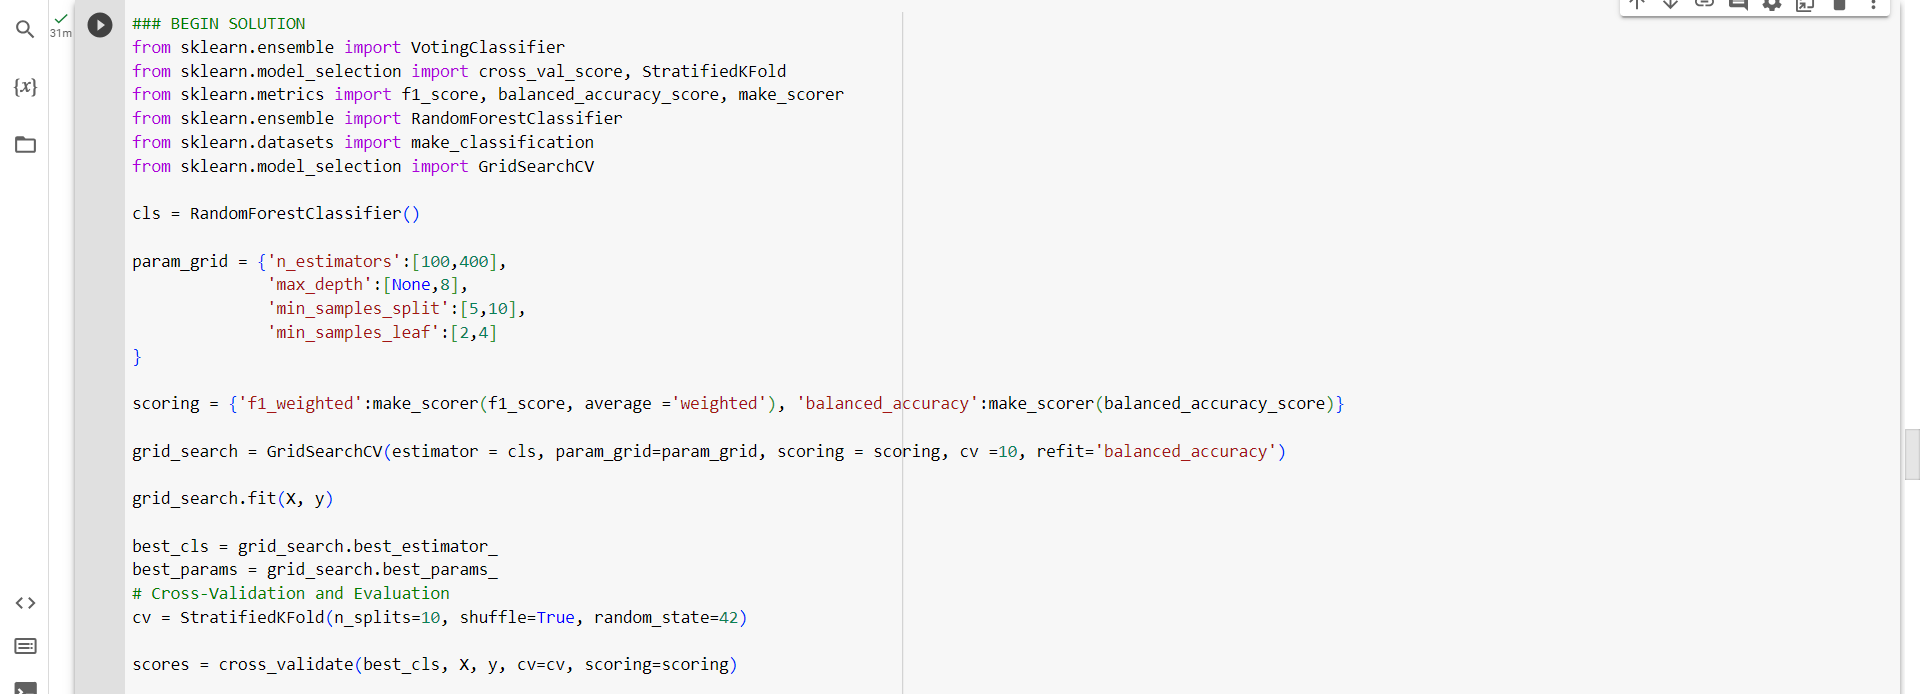

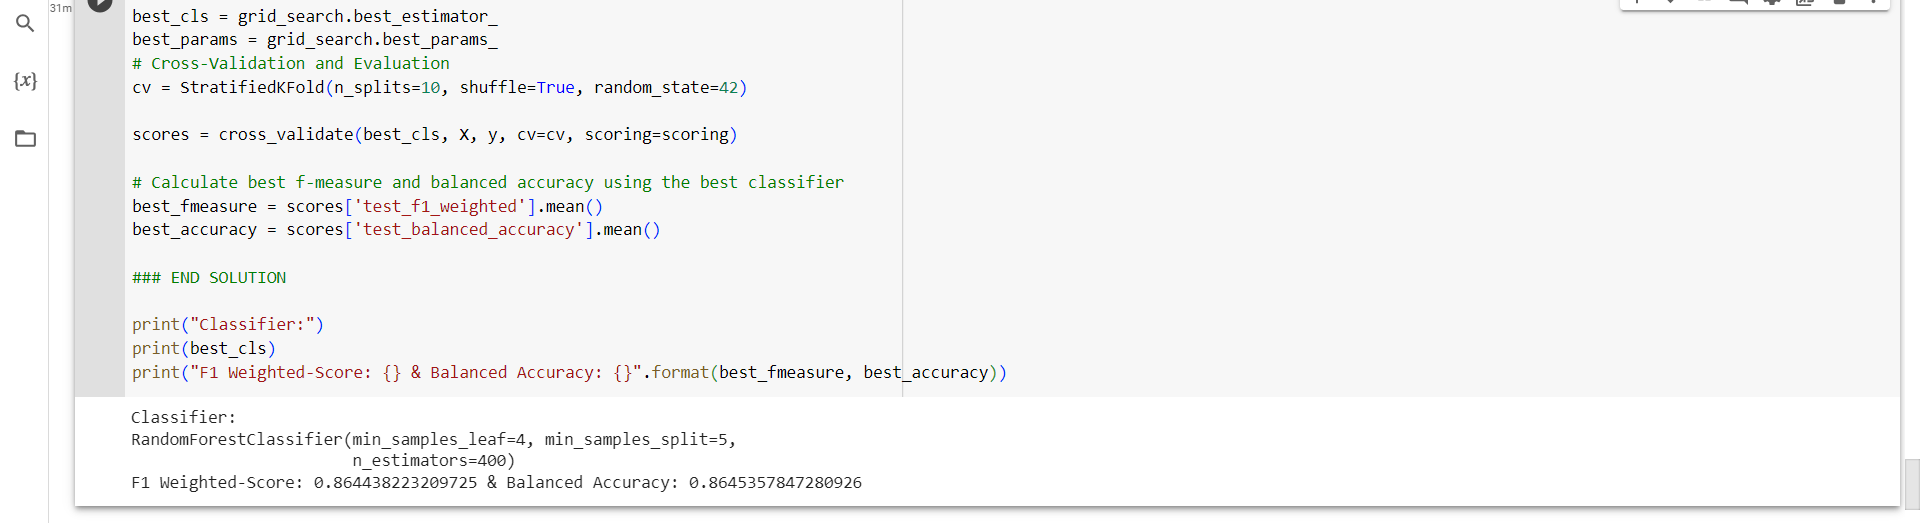

### 2.3 Setup the Final Classifier
Finally, in this last cell, set the cls variable to either the best model as occured by the stratified cross_validation, or choose to retrain your classifier in the whole dataset (X, y). There is no correct answer, but try to explain your choice. Then, save your model using pickle and upload it with your submission to e-learning!

In [ ]:
import pickle

### BEGIN SOLUTION
#επιλέγω τον classifier με τις καλύτερες αποδόσεις από τα προηγούμενα ερωτήματα ώστε να πετύχω κατά πάσα πιθανότητα καλά ποσοστά
#και στα άγνωστα δεδομένα. Επιλέγω να κάνω retrain, με κίνδυνο το overfitting αλλά αυξάνοντας τις πιθανότητες να βελτιωθούν περισσότερο
#οι μετρικές αξιολόγησης.
cls = best_cls.fit(X,y)

# save with pickle
file_name = "XGBcls.pkl"
pickle.dump(cls, open(file_name, "wb"))
### END SOLUTION


# load
cls = pickle.load(open(file_name, "rb"))

test_set = pd.read_csv("test_set_noclass.csv")
predictions = cls.predict(test_set)

# We are going to run the following code
if False:
  from sklearn.metrics import f1_score, balanced_accuracy_score
  final_test_set = pd.read_csv('test_set.csv')
  ground_truth = final_test_set['CLASS']
  print("Balanced Accuracy: {}".format(balanced_accuracy_score(predictions, ground_truth)))
  print("F1 Weighted-Score: {}".format(f1_score(predictions, ground_truth, average='weighted')))

Both metrics should aim above 82%! This is going to be tested by us! Make sure your cross validation or your retrained model achieves high balanced accuracy and f1_score (based on 2.1) (more than 88%) as it should achieve at least 82% in our unknown test set!


Please provide your feedback regarding this project! Did you enjoy it?

Παρόλο που η εργασία περιέχει λιγότερα ερωτήματα σε σχέση με τις 2 προηγούμενες, ήταν αρκετά στοχευμένα και συνέβαλαν στην εφαρμογή γνώσεων του μαθήματος.
Επίσης, ερχόμενη σε επαφή πρώτη φορά με το συγκεκριμένο κομμάτι ύλης, οι έννοιες έγιναν πολύ πιο κατανοητές μέσω του συγκεκριμένου κώδικα και απέκτησα
μεγαλύτερη εξοικείωση.
